In [1]:
library(brms)
theme_set(theme_default())

Loading required package: Rcpp
Loading required package: ggplot2
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.


# Load data

In [2]:
# load RData into environment object ("ex")
load("./prepped_data.RData", ex <- new.env())

In [3]:
# Load data from environment.
# For testing, we're using df_slice, which has only subjects 1 an 2.
#df <- ex$df_slice
df <- ex$df_total

In [4]:
head(df)

Answer,Block,CD,Choice,ED,RT,Trlnum,conNT,conNT_cent,item_id,newNT,newNT_cent,sub,task,task_order,ec_b2,ec_b3,ec_task,ec_taskorder
1,0,1.140978,0,15.32376,1.762020,0,8.711341,-0.02945527,16.0,6.996014,0.002536885,1,disc,ver1,-1,-1,-1,1
0,1,1.140978,1,15.32376,2.242939,33,8.711341,-0.02945527,16.0,6.996014,0.002536885,1,disc,ver1,1,0,-1,1
1,2,1.140978,0,15.32376,1.766368,39,8.711341,-0.02945527,16.0,6.996014,0.002536885,1,disc,ver1,0,1,-1,1
1,0,1.140978,0,15.32376,2.559490,38,8.711341,-0.02945527,16.0,6.996014,0.002536885,2,disc,ver1,-1,-1,-1,1
1,2,1.140978,0,15.32376,2.417423,51,8.711341,-0.02945527,16.0,6.996014,0.002536885,2,disc,ver1,0,1,-1,1
0,0,1.140978,1,15.32376,1.718840,2,8.711341,-0.02945527,16.0,6.996014,0.002536885,3,disc,ver2,-1,-1,-1,-1


In [5]:
str(df)

'data.frame':	11683 obs. of  19 variables:
 $ Answer      : Factor w/ 2 levels "0","1": 2 1 2 2 2 1 1 2 2 2 ...
 $ Block       : Factor w/ 3 levels "0","1","2": 1 2 3 1 3 1 2 3 1 2 ...
 $ CD          : num  1.14 1.14 1.14 1.14 1.14 ...
 $ Choice      : int  0 1 0 0 0 1 2 0 0 0 ...
 $ ED          : num  15.3 15.3 15.3 15.3 15.3 ...
 $ RT          : num  1.76 2.24 1.77 2.56 2.42 ...
 $ Trlnum      : int  0 33 39 38 51 2 51 46 31 6 ...
 $ conNT       : num  8.71 8.71 8.71 8.71 8.71 ...
 $ conNT_cent  : num  -0.0295 -0.0295 -0.0295 -0.0295 -0.0295 ...
 $ item_id     : Factor w/ 64 levels "0.0","1.0","10.0",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ newNT       : num  7 7 7 7 7 ...
 $ newNT_cent  : num  0.00254 0.00254 0.00254 0.00254 0.00254 ...
 $ sub         : Factor w/ 32 levels "1","10","11",..: 1 1 1 12 12 23 23 23 27 27 ...
 $ task        : Factor w/ 2 levels "disc","name": 1 1 1 1 1 1 1 1 1 1 ...
 $ task_order  : Factor w/ 2 levels "ver1","ver2": 1 1 1 1 1 2 2 2 2 2 ...
 $ ec_b2       : num  -1

# Null models

In [6]:
# assume only main effects for all our nuisance predictors (block, task, task_order)
# as fixed effects and random slopes across subjects
# with varying intercept for item_id
# Answer ~ ec_b2 + ec_b3 + task + task_order + (ec_b2 + ec_b3 + task + task_order|sub) + (1|item_id),
answer_nullmodel <- brm(Answer ~ ec_b2 + ec_b3 + task + task_order + (ec_b2 + ec_b3 + task + task_order|sub) + (1|item_id),
                        data=df,
                        family=bernoulli,
                        file="answer_nullmodel",
                        sample_prior=TRUE, save_all_pars=TRUE,
                        chains=2, cores=2)

In [7]:
# additional interaction between task and block
# Answer ~ ec_b2 + ec_b3 + task + ec_b2:task + ec_b3:task + task_order + (1|ec_b2 + ec_b3 + task + ec_b2:task + ec_b3:task + task_order) + (1|item_id),
answer_nullmodel2 <- brm(Answer ~ ec_b2 + ec_b3 + task + ec_b2:task + ec_b3:task + task_order + (1|ec_b2 + ec_b3 + task + ec_b2:task + ec_b3:task + task_order) + (1|item_id),
                        data=df,
                        family=bernoulli,
                        file="answer_nullmodel2",
                        sample_prior=TRUE, save_all_pars=TRUE,
                        chains=2, cores=2)

In [8]:
# interaction between task_order and block
# Answer ~ ec_b2 + ec_b3 + task_order + ec_b2:task_order + ec_b3:task_order + task + (1|ec_b2 + ec_b3 + task_order + ec_b2:task_order + ec_b3:task_order + task) + (1|item_id),
answer_nullmodel3 <- brm(Answer ~ ec_b2 + ec_b3 + task_order + ec_b2:task_order + ec_b3:task_order + task + (1|ec_b2 + ec_b3 + task_order + ec_b2:task_order + ec_b3:task_order + task) + (1|item_id),
                        data=df,
                        family=bernoulli,
                        file="answer_nullmodel3",
                        sample_prior=TRUE, save_all_pars=TRUE,
                        chains=2, cores=2)

In [9]:
# interaction between task and task_order
# Answer ~ ec_b2 + ec_b3 + task + task_order + task:task_order + (ec_b2 + ec_b3 + task + task_order + task:task_order|sub) + (1|item_id),
answer_nullmodel4 <- brm(Answer ~ ec_b2 + ec_b3 + task + task_order + task:task_order + (ec_b2 + ec_b3 + task + task_order + task:task_order|sub) + (1|item_id),
                        data=df,
                        family=bernoulli,
                        file="answer_nullmodel4",
                        sample_prior=TRUE, save_all_pars=TRUE,
                        chains=2, cores=2,
                        inits=0)

In [10]:
# all interactions (block, task, and task order)
# This is pretty long ...
# Answer ~ ec_b2 + ec_b3 + task + task_order + task:task_order + ec_b2:task + ec_b3:task + ec_b2:task:task_order + ec_b3:task:task_order + (ec_b2 + ec_b3 + task + task_order + task:task_order + ec_b2:task + ec_b3:task + ec_b2:task:task_order + ec_b3:task:task_order|sub) + (1|item_id)
answer_nullmodel5 <- brm(Answer ~ ec_b2 + ec_b3 + task + task_order + task:task_order + ec_b2:task + ec_b3:task + ec_b2:task:task_order + ec_b3:task:task_order + (ec_b2 + ec_b3 + task + task_order + task:task_order + ec_b2:task + ec_b3:task + ec_b2:task:task_order + ec_b3:task:task_order|sub) + (1|item_id),
                        data=df,
                        family=bernoulli,
                        file="answer_nullmodel5",
                        sample_prior=TRUE, save_all_pars=TRUE,
                        chains=2, cores=2,
                        inits=0)

Compare null models obtained so far

In [11]:
# takes a while to run
#loo_nullmodcomp <- LOO(answer_nullmodel, answer_nullmodel2, answer_nullmodel3, answer_nullmodel4, answer_nullmodel5)

Null model 4 is the best (with interaction between task and task order), though closely en par with 1 and 5.

Hence, our typicality models will be assigned the same rfx structure as null model number 4.

## Reduce RFX complexity of null models

- plot posteriors of the most complex null model (5).
- focus on random effects (^sd)
- See which posteriors have probability mass mostly around zero
- remove these as varying effects and re-run

In [13]:
#plot(answer_nullmodel5, pars="^sd")

SDs of interactions seem to have little effect. Remove them and re-run.

In [14]:
answer_nullmodel6 <- brm(Answer ~ ec_b2 + ec_b3 + task + task_order + task:task_order + (ec_b2 + ec_b3 + task + task_order|sub) + (1|item_id),
                        data=df,
                        family=bernoulli,
                        file="answer_nullmodel6",
                        sample_prior=TRUE, save_all_pars=TRUE,
                        chains=2, cores=2,
                        inits=0)

In [15]:
# All interactions as fixed but not random effects
answer_nullmodel7 <- brm(Answer ~ ec_b2 + ec_b3 + task + task_order + task:task_order + ec_b2:task + ec_b3:task + ec_b2:task:task_order + ec_b3:task:task_order + (ec_b2 + ec_b3 + task + task_order|sub) + (1|item_id),
                        data=df,
                        family=bernoulli,
                        file="answer_nullmodel7",
                        sample_prior=TRUE, save_all_pars=TRUE,
                        chains=2, cores=2,
                        inits=0)

compared all null models on the cluster, this is the output:

In [16]:
"""
                                         LOOIC    SE
answer_nullmodel                      13515.12 94.89
answer_nullmodel2                     14139.10 84.51
answer_nullmodel3                     14119.90 84.82
answer_nullmodel4                     13510.96 94.93
answer_nullmodel5                     13515.86 95.48
answer_nullmodel6                     13507.95 94.97
answer_nullmodel7                     13510.95 95.25
answer_nullmodel - answer_nullmodel2   -623.98 52.67
answer_nullmodel - answer_nullmodel3   -604.78 52.75
answer_nullmodel - answer_nullmodel4      4.16  4.20
answer_nullmodel - answer_nullmodel5     -0.74  7.80
answer_nullmodel - answer_nullmodel6      7.17  4.48
answer_nullmodel - answer_nullmodel7      4.17  8.74
answer_nullmodel2 - answer_nullmodel3    19.21  9.24
answer_nullmodel2 - answer_nullmodel4   628.15 52.89
answer_nullmodel2 - answer_nullmodel5   623.25 53.62
answer_nullmodel2 - answer_nullmodel6   631.16 52.84
answer_nullmodel2 - answer_nullmodel7   628.15 53.61
answer_nullmodel3 - answer_nullmodel4   608.94 53.04
answer_nullmodel3 - answer_nullmodel5   604.04 53.20
answer_nullmodel3 - answer_nullmodel6   611.95 52.95
answer_nullmodel3 - answer_nullmodel7   608.94 53.15
answer_nullmodel4 - answer_nullmodel5    -4.90  7.14
answer_nullmodel4 - answer_nullmodel6     3.01  2.52
answer_nullmodel4 - answer_nullmodel7     0.01  8.25
answer_nullmodel5 - answer_nullmodel6     7.91  7.36
answer_nullmodel5 - answer_nullmodel7     4.90  5.92
answer_nullmodel6 - answer_nullmodel7    -3.00  8.16
"""

ERROR: Error in parse(text = x, srcfile = src): <text>:1:3: unerwartete Zeichenkettenkonstante
30: answer_nullmodel6 - answer_nullmodel7    -3.00  8.16
31: "
      ^


- It seems that there is not really a drastic difference between the null models (considering SE).
- Except that null model 2 and 3 are worse than the rest
- Best is null model 6 (though not much so).

# Neural typicality models

## Both conserved and new NT in one model

In [17]:
# both NT measures, interacting with each other, block, and task (though not task order).
# also interaction task with block
# varying slopes for main effects across subjects
answer_bothNT <- brm(Answer ~ ec_b2 + ec_b3 + task + task_order + conNT + newNT + conNT:newNT + conNT:ec_b2 + conNT:ec_b3 + newNT:ec_b2 + newNT:ec_b3 + conNT:task + newNT:task + task:ec_b2 + task:ec_b3 (ec_b2 + ec_b3 + task + task_order + conNT + newNT|sub) + (1|item_id),
                        data=df,
                        family=bernoulli,
                        file="answer_bothNT",
                        sample_prior=TRUE, save_all_pars=TRUE,
                        chains=2, cores=2)

In [18]:
# new NT, same structure (except interaction with conNT)
answer_newNT <- brm(ec_b2 + ec_b3 + task + task_order + newNT + newNT:ec_b2 + newNT:ec_b3 + newNT:task + task:ec_b2 + task:ec_b3 + (ec_b2 + ec_b3 + task + task_order + newNT|sub) + (1|item_id),
                    data=df,
                    family=bernoulli,
                    file="answer_newNT",
                    sample_prior=TRUE, save_all_pars=TRUE,
                    chains=2, cores=2)

In [19]:
# new NT, same structure (except interaction with conNT)
answer_conNT <- brm(ec_b2 + ec_b3 + task + task_order + conNT + conNT:ec_b2 + conNT:ec_b3 + conNT:task + task:ec_b2 + task:ec_b3 (ec_b2 + ec_b3 + task + task_order + conNT|sub) + (1|item_id),
                    data=df,
                    family=bernoulli,
                    file="answer_conNT",
                    sample_prior=TRUE, save_all_pars=TRUE,
                    chains=2, cores=2)

Compare neural typicality models (with each other and null model)

# Model comparison

In [20]:
loo_modcomp <- readRDS('loo_modcomp.RDS')

In [21]:
print(loo_modcomp)

                                         LOOIC    SE
answer_nullmodel                      13515.12 94.89
answer_nullmodel2                     14139.10 84.51
answer_nullmodel3                     14119.90 84.82
answer_nullmodel4                     13510.96 94.93
answer_nullmodel5                     13515.86 95.48
answer_nullmodel6                     13507.95 94.97
answer_nullmodel7                     13510.95 95.25
answer_bothNT                         13491.35 95.60
answer_newNT                          13497.33 95.47
answer_conNT                          13507.57 95.32
answer_nullmodel - answer_nullmodel2   -623.98 52.67
answer_nullmodel - answer_nullmodel3   -604.78 52.75
answer_nullmodel - answer_nullmodel4      4.16  4.20
answer_nullmodel - answer_nullmodel5     -0.74  7.80
answer_nullmodel - answer_nullmodel6      7.17  4.48
answer_nullmodel - answer_nullmodel7      4.17  8.74
answer_nullmodel - answer_bothNT         23.77 10.52
answer_nullmodel - answer_newNT          17.79

Compared to ...
- null model 1
    - all three NT models are better, small differences (relative to SE)
- null model 2
    - all three NT models are better, large differences
- null model 3
    - all three NT models are better, large differences
- null model 4
    - bothNT and newNT are slightly better, conNT is not
- null model 5
    - bothNT and newNT are slightly better, conNT is not
- null model 6
    - bohtNT is slightly better, conNT and newNT are not
- null model 7
    - bothNT is slightly better, conNT and newNT are not
    
In general, the bothNT model is better than the individual ones

# Visualization

In [23]:
# all posteriors
#plot(answer_bothNT, ask = FALSE)

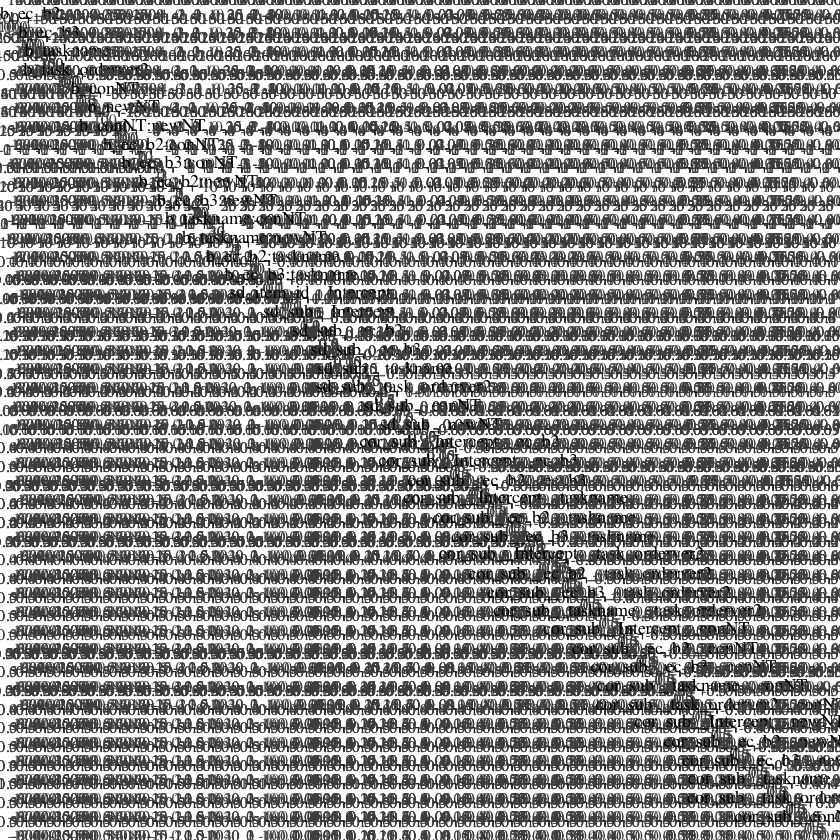

In [32]:
pairs(answer_bothNT)

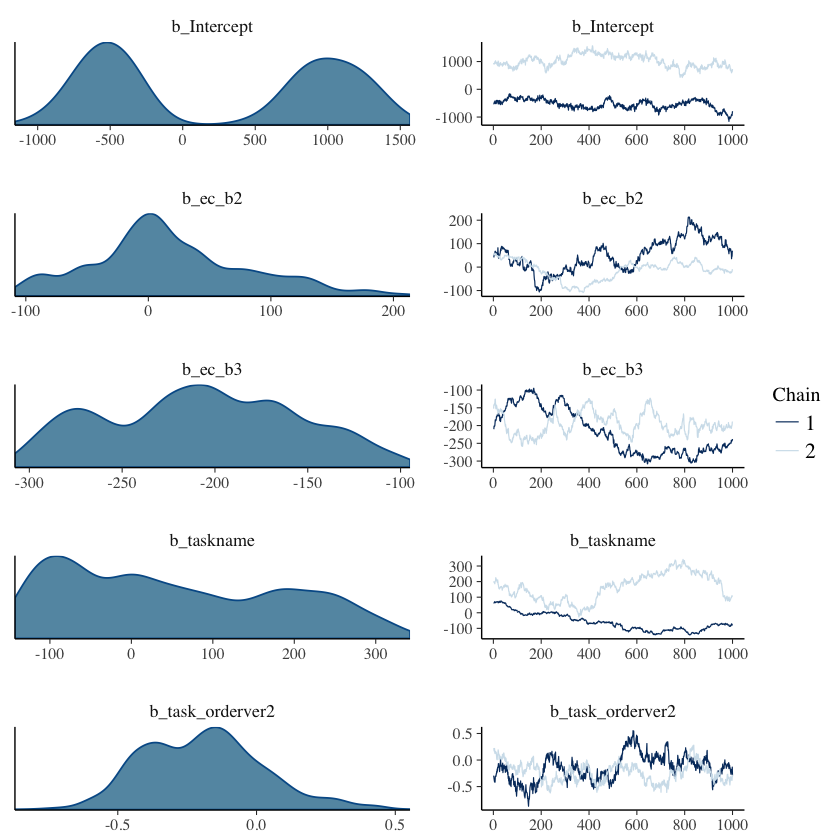

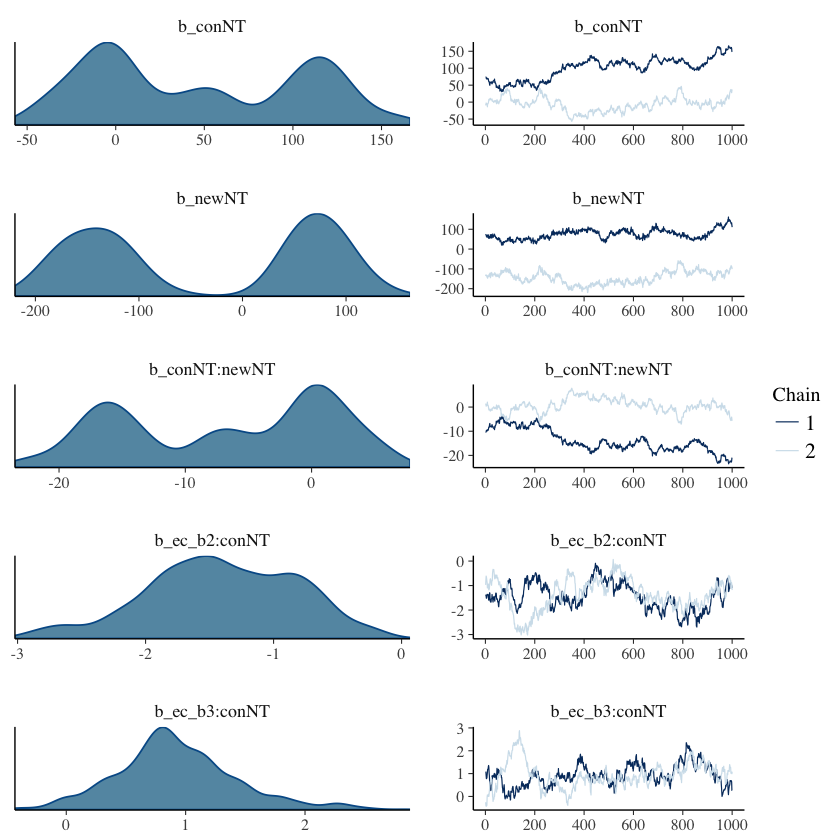

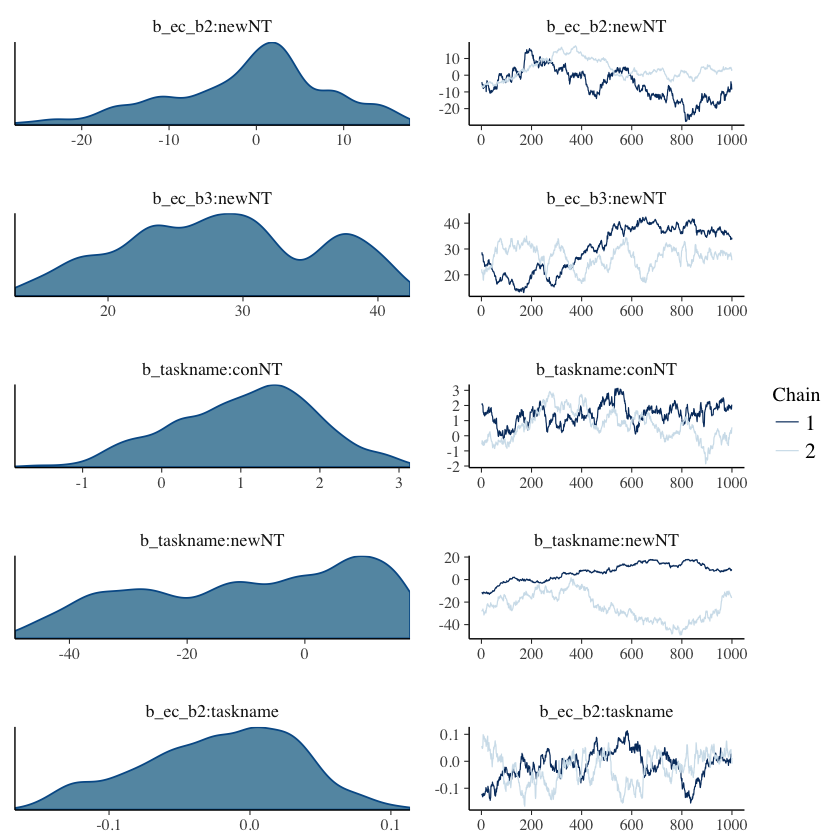

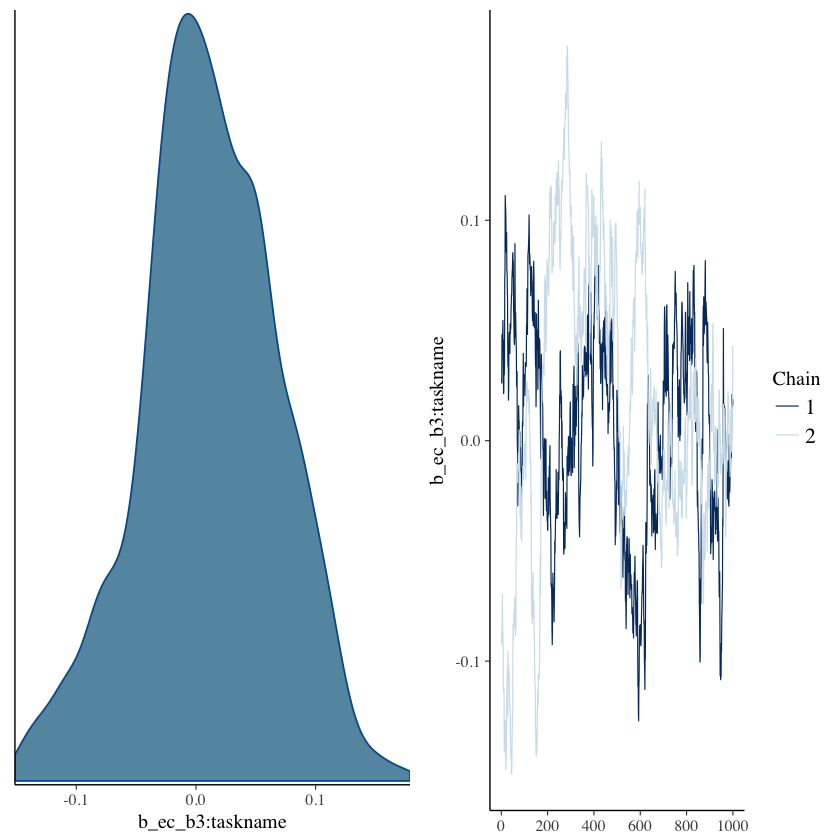

In [30]:
# Only regression weights posteriors
plot(answer_bothNT, pars="^b")

In [25]:
# check distribution of predictions
#pp_check(answer_bothNT)

In [31]:
# Prediction by marginalized effects
#plot(marginal_effects(answer_bothNT), ask = FALSE)

# Sandbox

## Hypothesis testing (main effects)

In [19]:
prior <- get_prior(Answer ~ conNT_cent*Block*task + (conNT_cent*Block*task|sub) + (1|item_id),
                  data=df,
                  family=bernoulli)

In [25]:
# set prior for all population level effects at once.
# problem, their posteriors have drastically different ranges (see above).
#prior$prior[1] <- "normal(0,10)"

# set prior for the beta weight of specific predictor (x1)
#set_prior("normal(0,5)", class = "b", coef = "x1")



prior,class,coef,group,resp,dpar,nlpar,bound
"normal(0,5)",b,,,,,,


prior,class,coef,group,resp,dpar,nlpar,bound
,b,,,,,,
,b,Block1,,,,,
,b,Block1:taskname,,,,,
,b,Block2,,,,,
,b,Block2:taskname,,,,,
,b,conNT_cent,,,,,
,b,conNT_cent:Block1,,,,,
,b,conNT_cent:Block1:taskname,,,,,
,b,conNT_cent:Block2,,,,,
,b,conNT_cent:Block2:taskname,,,,,


In [23]:
prior

prior,class,coef,group,resp,dpar,nlpar,bound
"normal(0,10)",b,,,,,,
,b,Block1,,,,,
,b,Block1:taskname,,,,,
,b,Block2,,,,,
,b,Block2:taskname,,,,,
,b,conNT_cent,,,,,
,b,conNT_cent:Block1,,,,,
,b,conNT_cent:Block1:taskname,,,,,
,b,conNT_cent:Block2,,,,,
,b,conNT_cent:Block2:taskname,,,,,


In [ ]:
answer_conNT <- brm(Answer ~ conNT_cent*Block*task + (conNT_cent*Block*task|sub) + (1|item_id),
                    data=df,
                    family=bernoulli,
                    file="answer_conNT",
                    sample_prior=TRUE, save_all_pars=TRUE,
                    chains=2, cores=2)

In [27]:
#model_weights(answer_bothNT)  # takes long

In [28]:
hblock1 <- hypothesis(answer_bothNT, "Block1 = 0")

In [29]:
print(hblock1)

Hypothesis Tests for class b:
    Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio Post.Prob Star
1 (Block1) = 0     0.19      0.09     0.02     0.36         NA        NA    *
---
'*': The expected value under the hypothesis lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.


In [32]:
hblock2 <- hypothesis(answer_bothNT, "Block2 = 0")

In [33]:
print(hblock2)

Hypothesis Tests for class b:
    Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio Post.Prob Star
1 (Block2) = 0     0.21      0.09     0.04     0.41         NA        NA    *
---
'*': The expected value under the hypothesis lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.


In [34]:
hblock3 <- hypothesis(answer_bothNT, "Block2 = Block 1")

In [35]:
print(hblock3)

Hypothesis Tests for class b:
             Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (Block2)-(Block1) = 0     0.02      0.09    -0.16     0.21         NA
  Post.Prob Star
1        NA     
---
'*': The expected value under the hypothesis lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.


So both block 2 and 3 are significantly different from block 1 (the intercept), but not from each other.

In [38]:
#thepriors <- prior_summary(answer_bothNT)

# TODO

## Interpretability

- Effect coding for categorical predictors (Block)
- Normalize all NT / ED measures by their SD

## Hypothesis testing

- Assess contrasts
- Reduce model complexity and compare with LOO
- Look for estimated SD parameters for random interactions, remove them if they don't appear significant (to reduce complexigy), and run the simpler model(s). Then do model comparison

## Outlier evaluation

- Compare models based on data including and excluding outliers.